In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data = pd.read_csv("df_final.csv")
data.shape

/tmp/ipykernel_3303/1621852662.py:1: DtypeWarning: Columns (1,19,20,21,22,34,39,40,41,42,43,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("df_final.csv")


(5017137, 54)

In [6]:
df = data.copy()

In [33]:
df_prediction = df[['dd','ff','t','td','precip','hu', 'incendie']]
print(df_prediction.shape)
df_prediction = df_prediction.dropna()
print(df_prediction.shape)
X = df_prediction[['dd','ff','t','td','precip','hu']]
y = df_prediction['incendie']
y.sum()

(5017137, 7)
(2019491, 7)


898

AUC-ROC: 0.8285520726069382
[[283299 120424]
 [    43    133]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    403723
           1       0.00      0.76      0.00       176

    accuracy                           0.70    403899
   macro avg       0.50      0.73      0.41    403899
weighted avg       1.00      0.70      0.82    403899



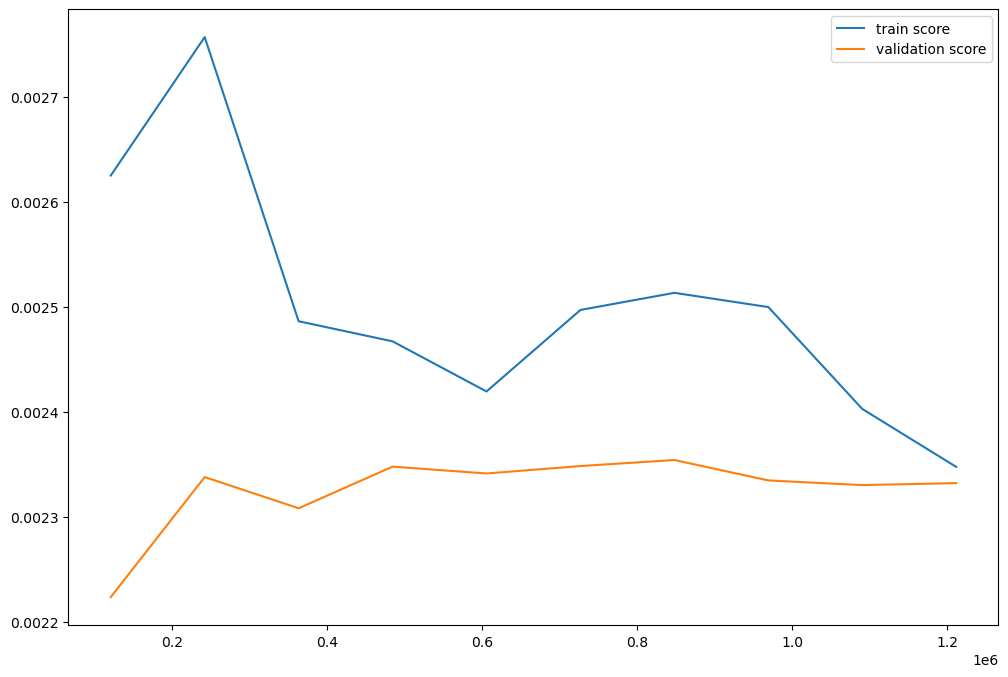

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Créer et entraîner le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([('scaler',StandardScaler()),
                      ('classi',LogisticRegression(class_weight='balanced'))]
                     )
model.fit(X_train, y_train)

# Obtenir les probabilités sur l'ensemble de test
probabilities = model.predict_proba(X_test)

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_test, probabilities[:, 1])  # Utiliser les probabilités de la classe 1 (incendie)
print(f'AUC-ROC: {auc_roc}')
evaluation(model)

In [63]:
ypred = model.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[283299 120424]
 [    43    133]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    403723
           1       0.00      0.76      0.00       176

    accuracy                           0.70    403899
   macro avg       0.50      0.73      0.41    403899
weighted avg       1.00      0.70      0.82    403899



In [56]:
proba0 = model.predict_proba(X_test[y_test==0])
proba1 = model.predict_proba(X_test[y_test==1])

(array([2.68142469e-02, 8.38258467e-01, 1.93964739e+00, 2.81950553e+00,
        2.96861280e+00, 2.96159598e+00, 2.91648790e+00, 2.55888108e+00,
        2.36742234e+00, 2.13737114e+00, 1.99678429e+00, 1.91609095e+00,
        1.74016945e+00, 1.80933517e+00, 1.63491726e+00, 1.77124390e+00,
        1.59356819e+00, 1.51087004e+00, 1.36151218e+00, 1.48405580e+00,
        1.44421033e+00, 1.36827839e+00, 1.17230885e+00, 1.29259706e+00,
        1.19135448e+00, 1.18534007e+00, 1.23094935e+00, 1.16028003e+00,
        1.11617435e+00, 1.09061311e+00, 1.19235689e+00, 1.01417997e+00,
        1.05552905e+00, 9.88869331e-01, 1.09813112e+00, 1.06981327e+00,
        1.03447861e+00, 9.33737234e-01, 1.14399100e+00, 8.87376153e-01,
        8.81862943e-01, 1.00490776e+00, 1.13647299e+00, 8.95395367e-01,
        9.59799680e-01, 9.64059887e-01, 9.63809287e-01, 8.93891764e-01,
        9.15944603e-01, 8.13699624e-01, 9.22710815e-01, 8.92638762e-01,
        8.73342528e-01, 9.45264854e-01, 7.86384176e-01, 9.460166

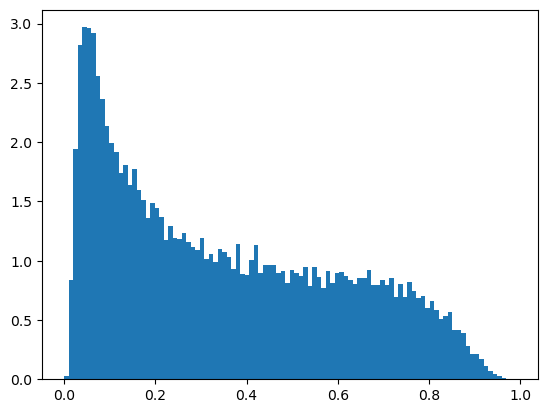

In [64]:
plt.hist(proba0[:,1], density=True, bins=100)

(array([0.24665898, 0.        , 0.        , 0.24665898, 0.49331797,
        0.36998848, 0.98663593, 0.49331797, 1.10996543, 1.4799539 ,
        0.86330644, 1.10996543, 1.35662441, 1.23329492, 1.10996543,
        2.71324882, 2.09660136, 3.32989628, 1.4799539 , 0.98663593]),
 array([0.05101952, 0.09708975, 0.14315998, 0.18923021, 0.23530044,
        0.28137067, 0.3274409 , 0.37351113, 0.41958136, 0.4656516 ,
        0.51172183, 0.55779206, 0.60386229, 0.64993252, 0.69600275,
        0.74207298, 0.78814321, 0.83421344, 0.88028368, 0.92635391,
        0.97242414]),
 <BarContainer object of 20 artists>)

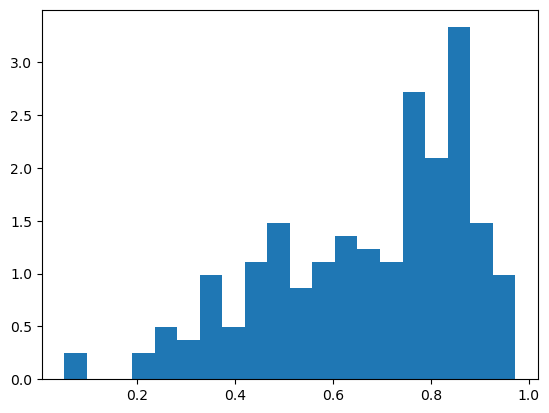

In [66]:
plt.hist(proba1[:,1], density=True, bins=20)

In [61]:
model.named_steps['classi'].coef_

array([[ 0.02300224,  0.25041865, -1.10558163,  1.51588547,  0.08119672,
        -1.75324936]])

In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = Pipeline([('scaler',StandardScaler()),
                      ('classi',AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    algorithm="SAMME.R",
    learning_rate=0.5
))]
                     )
ada.fit(X_train, y_train)

# Obtenir les probabilités sur l'ensemble de test
proba0_ada = ada.predict_proba(X_test[y_test==0])
proba1_ada = ada.predict_proba(X_test[y_test==1])

ypred = ada.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

#evaluation(rf)

[[403723      0]
 [   176      0]]


/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    403723
           1       0.00      0.00      0.00       176

    accuracy                           1.00    403899
   macro avg       0.50      0.50      0.50    403899
weighted avg       1.00      1.00      1.00    403899



/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
